### exp: eqtl prediction, slope prediction, enformer_pca for machine learning

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
model_size = ['small','middle','large']
model_list = ['xgboost','lightgbm','random forest','knn','svm']
tissue = 'Heart_Left_Ventricle'
data_path = '../../../../../datasets_embedding/enformer_pca/eqtl_datasets/slope_prediction/' + tissue + '/'
image_path = 'images_shuffled_seed510/'
# set seed
seed = 510
import random
random.seed(seed)
np.random.seed(seed)

#### small model

In [3]:
model = model_size[0]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['enformer_pca_before'][i].flatten().tolist()
    feature_list += train_data['enformer_pca_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['slope'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['enformer_pca_before'][i].flatten().tolist()
    feature_list += test_data['enformer_pca_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['slope'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

              variant_id     slope  \
0   chr1_3900688_T_C_b38  0.342601   
1  chr1_20508117_C_A_b38  0.276024   
2  chr1_25820023_G_C_b38  0.513832   
3  chr1_25820023_G_C_b38  0.530491   
4  chr1_27634281_G_A_b38  0.523637   

                                 enformer_pca_before  \
0  [[-47.389263, 17.172071, 4.4252286, 24.45965, ...   
1  [[-46.71026, -49.93919, -5.246285, 22.846962, ...   
2  [[-74.80549, 1.2245412, -24.921898, 39.529686,...   
3  [[-74.80555, 1.2244576, -24.922007, 39.529697,...   
4  [[-28.759605, 40.543064, -49.00757, -7.4581914...   

                                  enformer_pca_after  
0  [[-47.45171, 17.190142, 4.484114, 24.391283, -...  
1  [[-47.006683, -49.855934, -5.038793, 22.798998...  
2  [[-74.90514, 1.8903617, -25.012545, 40.296658,...  
3  [[-74.90463, 1.8903731, -25.012646, 40.296593,...  
4  [[-28.330627, 42.71442, -46.69989, -7.3497458,...  
X_train shape: (216, 17920)
Y_train shape: (216,)
X_test shape: (24, 17920)
Y_test shape: (24,)


##### model 1: xgboost

In [4]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': 300}
{'max_depth': 5}


rmse= 0.7737456810391904
r2= -0.11026310287257335
pcc= 0.2817354217998782
pcc_p= 0.1822887714506236


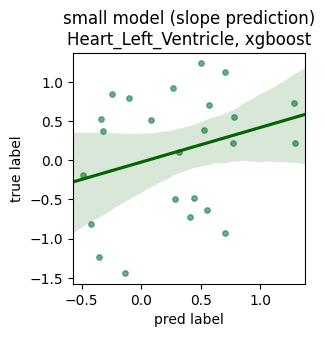

In [5]:
ml_model = model_list[0]

clf_xgb = xgb.XGBRegressor(n_estimators=n_estimators,  max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_pred = clf_xgb.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [6]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'max_depth': 1}
{'num_leaves': 2}


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.249621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1319912
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 17920
[LightGBM] [Info] Start training from score 0.212351
rmse= 0.8261088419251449
r2= -0.26562187483993505
pcc= -0.11760605903581704
pcc_p= 0.5841740267611909


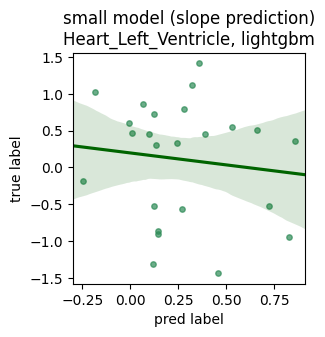

In [7]:
ml_model = model_list[1]

clf_lgb = lgb.LGBMRegressor(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_pred = clf_lgb.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

{'n_estimators': 52}
{'max_depth': 3}


rmse= 0.7480775707039107
r2= -0.03782158453395401
pcc= 0.1494660922585055
pcc_p= 0.48575689151755663


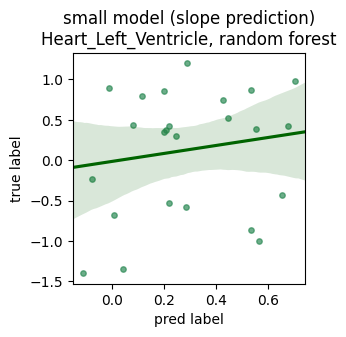

In [9]:
ml_model = model_list[2]
clf_rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_pred = clf_rf.predict(X_test)        

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# 1:search 'n_estimators'
paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsRegressor()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': 100}

rmse= 0.7474948116848953
r2= -0.03620527002334506
pcc= 0.1258765892565307
pcc_p= 0.5578177146713825


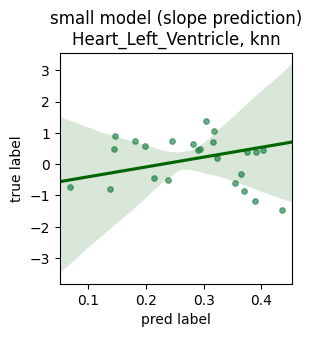

In [11]:
ml_model = model_list[3]
clf_knn = KNeighborsRegressor(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_pred = clf_knn.predict(X_test)    

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [4]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

{'gamma': 0.0001}
{'C': 0.01}


rmse= 0.7818672185236898
r2= -0.13369293734671017
pcc= nan
pcc_p= nan


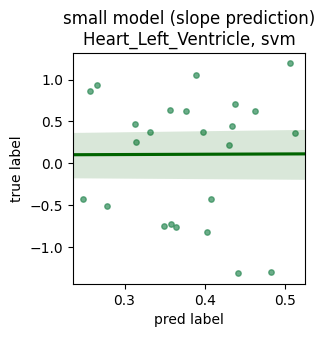

In [5]:
ml_model = model_list[4]
clf_svm = SVR(gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_pred = clf_svm.predict(X_test)  

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### middle model

In [6]:
model = model_size[1]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['enformer_pca_before'][i].flatten().tolist()
    feature_list += train_data['enformer_pca_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['slope'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['enformer_pca_before'][i].flatten().tolist()
    feature_list += test_data['enformer_pca_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['slope'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

              variant_id     slope  \
0   chr1_3891607_T_C_b38  0.807717   
1   chr1_6262459_G_C_b38  1.232429   
2  chr1_16988930_G_A_b38  0.309680   
3  chr1_37997832_C_T_b38  0.426557   
4  chr1_61723869_T_C_b38  0.233419   

                                 enformer_pca_before  \
0  [[-54.255074, 19.75534, 14.651023, -12.296424,...   
1  [[77.7633, 301.24112, 227.43211, 96.21968, 75....   
2  [[-24.199347, -25.074, 2.2626317, -3.375538, 4...   
3  [[-38.606823, -39.963745, -7.986763, 16.639215...   
4  [[-24.758663, 17.853453, 2.9821374, -19.989668...   

                                  enformer_pca_after  
0  [[-54.245617, 19.755568, 14.68431, -12.20483, ...  
1  [[77.76333, 301.05466, 227.57315, 95.232285, 4...  
2  [[-24.204699, -25.077372, 2.25911, -3.3884797,...  
3  [[-38.636524, -39.992935, -8.007092, 16.643051...  
4  [[-24.670155, 17.96288, 3.0367477, -20.63529, ...  
X_train shape: (220, 17920)
Y_train shape: (220,)
X_test shape: (25, 17920)
Y_test shape: (25,)


##### model 1: xgboost

In [7]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': 300}
{'max_depth': 4}


rmse= 1.0433896856913953
r2= -0.3366662579462285
pcc= -0.28224036662612284
pcc_p= 0.1716457363665839


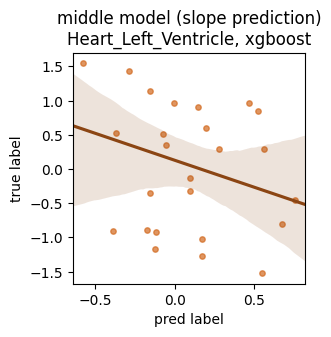

In [8]:
ml_model = model_list[0]

clf_xgb = xgb.XGBRegressor(n_estimators=n_estimators,  max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_pred = clf_xgb.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [9]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'max_depth': 11}
{'num_leaves': 14}


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1343952
[LightGBM] [Info] Number of data points in the train set: 220, number of used features: 17920
[LightGBM] [Info] Start training from score 0.011014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

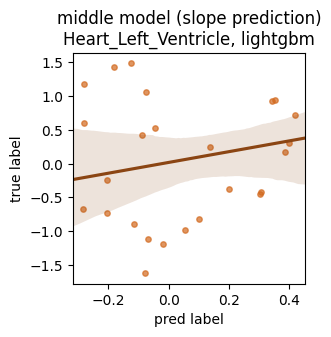

In [10]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMRegressor(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_pred = clf_lgb.predict(X_test)   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

{'n_estimators': 94}
{'max_depth': 7}


rmse= 0.8888983933745008
r2= 0.029860585962427688
pcc= 0.19698861091994238
pcc_p= 0.3452665883321021


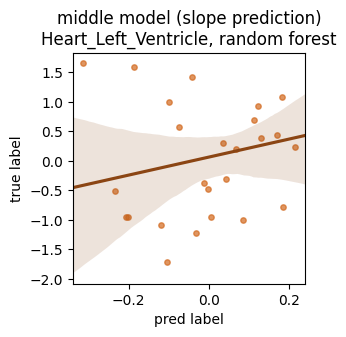

In [12]:
ml_model = model_list[2]
clf_rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_pred = clf_rf.predict(X_test)         

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# 1:search 'n_estimators'
paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsRegressor()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': 100}

rmse= 0.9002012211642542
r2= 0.005032025544963847
pcc= 0.19729017071895683
pcc_p= 0.3445137539222513


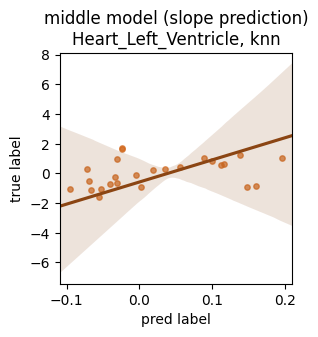

In [14]:
ml_model = model_list[3]
clf_knn = KNeighborsRegressor(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_pred = clf_knn.predict(X_test)  

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [15]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

{'gamma': 0.0001}
{'C': 10}


rmse= 0.9030847251562689
r2= -0.0013523005522209086
pcc= nan
pcc_p= nan


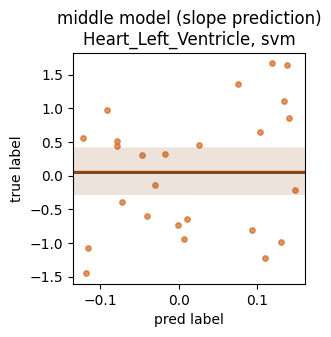

In [16]:
ml_model = model_list[4]
clf_svm = SVR(gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_pred = clf_svm.predict(X_test)      

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### large model

In [17]:
model = model_size[2]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

merged_data = pd.concat([train_data, valid_data, test_data]) # for machine learning, grid search
# new split
merged_data = merged_data.sample(frac=1).reset_index(drop=True)
train_data = merged_data[0:int(0.9*len(merged_data))].reset_index(drop=True)
test_data = merged_data[int(0.9*len(merged_data)):].reset_index(drop=True)

sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['enformer_pca_before'][i].flatten().tolist()
    feature_list += train_data['enformer_pca_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['slope'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['enformer_pca_before'][i].flatten().tolist()
    feature_list += test_data['enformer_pca_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['slope'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

              variant_id     slope  \
0   chr1_3913050_A_G_b38  0.803954   
1  chr1_16577626_T_G_b38  0.370057   
2  chr1_16907772_T_A_b38  0.406539   
3  chr1_23383982_C_T_b38  0.215370   
4  chr1_27335461_C_T_b38  1.098259   

                                 enformer_pca_before  \
0  [[42.65503, -44.591084, -54.048416, 36.171124,...   
1  [[90.61964, -72.04891, -28.534737, -7.966831, ...   
2  [[-72.820564, 16.17231, -21.322054, -9.705367,...   
3  [[-62.254154, 56.865253, 80.1686, 36.277443, -...   
4  [[-64.84281, 29.99895, -21.356176, -6.98703, -...   

                                  enformer_pca_after  
0  [[42.640003, -44.571423, -54.057346, 36.50962,...  
1  [[90.55814, -72.17049, -28.520075, -7.849138, ...  
2  [[-72.801994, 16.274057, -21.254602, -9.776959...  
3  [[-62.228954, 56.85493, 79.956535, 36.256065, ...  
4  [[-65.33001, 28.743313, -21.384493, -6.85759, ...  
X_train shape: (383, 17920)
Y_train shape: (383,)
X_test shape: (43, 17920)
Y_test shape: (43,)


##### model 1: xgboost

In [18]:
# model 1: xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 300, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed)
# https://scikit-learn.org/stable/modules/model_evaluation.html
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
n_estimators = gs.best_params_['n_estimators']
print(gs.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 
xgb_model = xgb.XGBRegressor(seed=seed,n_estimators=n_estimators)
gs = GridSearchCV(xgb_model, cv_params, refit=True, cv=5, scoring='neg_mean_absolute_error')
gs.fit(X_train,Y_train)
max_depth = gs.best_params_['max_depth']
print(gs.best_params_)

{'n_estimators': 42}
{'max_depth': 3}


rmse= 0.7515832454373887
r2= 0.1788354694817451
pcc= 0.4264492783203171
pcc_p= 0.004350323200255927


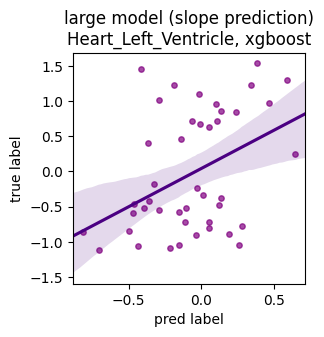

In [19]:
ml_model = model_list[0]
clf_xgb = xgb.XGBRegressor(n_estimators=n_estimators,  max_depth=max_depth) # from grid search
clf_xgb.fit(X_train,Y_train)

y_pred = clf_xgb.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:lightgbm

In [20]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
max_depth = gsearch.best_params_['max_depth']
print(gsearch.best_params_)

cv_params = {'num_leaves': np.linspace(2, 50, 5, dtype=int)} # 
gbm = lgb.LGBMRegressor(seed=seed,max_depth=max_depth,verbose=-1)
gsearch = GridSearchCV(gbm, param_grid=cv_params, cv=5, scoring='neg_mean_absolute_error')
gsearch.fit(X_train, Y_train)
num_leaves = gsearch.best_params_['num_leaves']
print(gsearch.best_params_)

{'max_depth': 6}
{'num_leaves': 14}


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.231275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2301572
[LightGBM] [Info] Number of data points in the train set: 383, number of used features: 17920
[LightGBM] [Info] Start training from score 0.068864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

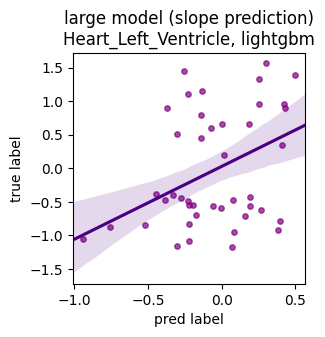

In [21]:
ml_model = model_list[1]
clf_lgb = lgb.LGBMRegressor(max_depth=max_depth, num_leaves=num_leaves)
clf_lgb.fit(X_train,Y_train)

y_pred = clf_lgb.predict(X_test)         

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: random forest

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

cv_params = {'n_estimators': np.linspace(10, 200, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed))
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
n_estimators = grid.best_params_['n_estimators']
print(grid.best_params_)

cv_params = {'max_depth': np.linspace(1, 10, 10, dtype=int)} # 200
rfModel = RandomForestRegressor(random_state = random.seed(seed),n_estimators=n_estimators)
grid = GridSearchCV(
    rfModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
max_depth=grid.best_params_['max_depth']
print(grid.best_params_)

{'n_estimators': 52}
{'max_depth': 9}


rmse= 0.7611878625188775
r2= 0.15771374961279128
pcc= 0.44838504131396667
pcc_p= 0.0025655439419744364


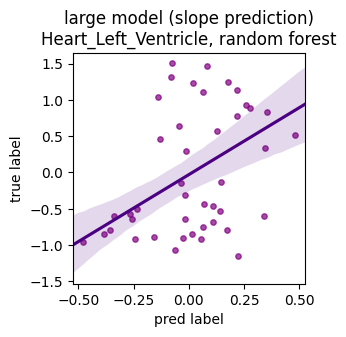

In [23]:
ml_model = model_list[2]
clf_rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
clf_rf.fit(X_train,Y_train)

y_pred = clf_rf.predict(X_test)   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 4: knn

In [24]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# 1:search 'n_estimators'
paramGride = {'n_neighbors': np.linspace(100, 300, 10, dtype=int)} 

knnModel = KNeighborsRegressor()
grid = GridSearchCV(
    knnModel,paramGride,cv = 5,return_train_score = True, scoring='roc_auc')
grid = grid.fit(X_train,Y_train)
grid.best_params_

{'n_neighbors': 100}

rmse= 0.9059932855098878
r2= -0.1932349352728684
pcc= -0.14384509821578992
pcc_p= 0.35743757255327574


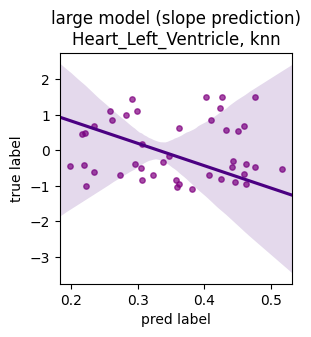

In [25]:
ml_model = model_list[3]
clf_knn = KNeighborsRegressor(n_neighbors = grid.best_params_['n_neighbors'])
clf_knn.fit(X_train,Y_train)

y_pred = clf_knn.predict(X_test)   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 5: svm

In [26]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

cv_params = {'gamma': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR()
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
gamma = grid.best_params_['gamma']
print(grid.best_params_)

cv_params = {'C': [1e-4,1e-3,1e-2,1e-1,1,10,100,1000]} # 33
svmModel = SVR(gamma=gamma)
grid = GridSearchCV(
    svmModel,cv_params,cv = 5,return_train_score = True, scoring='neg_mean_absolute_error')
grid = grid.fit(X_train,Y_train)
C = grid.best_params_['C']
print(grid.best_params_)

{'gamma': 0.0001}
{'C': 1000}


rmse= 0.7971024796858931
r2= 0.07635661911386715
pcc= 0.2864138203094773
pcc_p= 0.06260043512860235


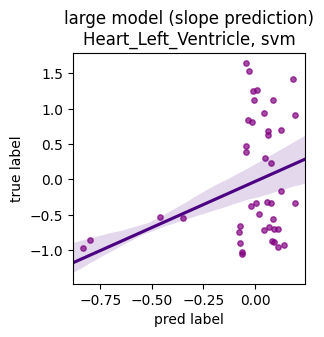

In [27]:
ml_model = model_list[4]
clf_svm = SVR(gamma = gamma, C = C)
clf_svm.fit(X_train,Y_train)

y_pred = clf_svm.predict(X_test)      

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()